# Titanic Survival Prediction

**Objective:** Predict passenger survival using machine learning algorithms.

**Dataset:** Titanic - Training and Test sets

**Approach:** Feature engineering, model comparison, and hyperparameter optimization with Random Forest and ensemble methods.

## Setup - Import Libraries and Load Data

In [1]:
# Import necessary libraries
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# Load datasets
df_train = pl.read_csv("../datasets/titanic/train.csv")
df_test = pl.read_csv("../datasets/titanic/test.csv")

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")

Training set shape: (891, 12)
Test set shape: (418, 11)


In [3]:
# Explore the data
df_train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""
4,1,1,"""Futrelle, Mrs. Jacques Heath (…","""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,"""Allen, Mr. William Henry""","""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In [4]:
# Check for missing values
print("Missing values in training set:")
print(df_train.null_count())

Missing values in training set:
shape: (1, 12)
┌─────────────┬──────────┬────────┬──────┬───┬────────┬──────┬───────┬──────────┐
│ PassengerId ┆ Survived ┆ Pclass ┆ Name ┆ … ┆ Ticket ┆ Fare ┆ Cabin ┆ Embarked │
│ ---         ┆ ---      ┆ ---    ┆ ---  ┆   ┆ ---    ┆ ---  ┆ ---   ┆ ---      │
│ u32         ┆ u32      ┆ u32    ┆ u32  ┆   ┆ u32    ┆ u32  ┆ u32   ┆ u32      │
╞═════════════╪══════════╪════════╪══════╪═══╪════════╪══════╪═══════╪══════════╡
│ 0           ┆ 0        ┆ 0      ┆ 0    ┆ … ┆ 0      ┆ 0    ┆ 687   ┆ 2        │
└─────────────┴──────────┴────────┴──────┴───┴────────┴──────┴───────┴──────────┘


## Data Preprocessing

In [5]:
def preprocess_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Preprocess Titanic dataset:
    - Fill missing values (Age, Fare, Embarked)
    - Encode categorical features (Sex, Embarked)
    
    Args:
        df: Raw Polars DataFrame
    
    Returns:
        Preprocessed DataFrame with encoded features
    """
    # Fill missing values
    df = df.with_columns([
        pl.col("Age").fill_null(pl.col("Age").median()),
        pl.col("Fare").fill_null(pl.col("Fare").median()),
        pl.col("Embarked").fill_null("S")  # Most common value
    ])
    
    # Encode Sex: male=1, female=0
    df = df.with_columns([
        (pl.col("Sex") == "male").cast(pl.Int32).alias("Sex_num")
    ])
    
    # Encode Embarked: S=0, C=1, Q=2
    df = df.with_columns([
        pl.col("Embarked")
          .replace({"S": 0, "C": 1, "Q": 2})
          .cast(pl.Int32)
          .alias("Embarked_num")
    ])
    
    return df

# Preprocess both datasets
df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

print("✓ Preprocessing complete!")

✓ Preprocessing complete!


In [6]:
# Define feature columns for baseline model
FEATURE_COLUMNS = ["Pclass", "Sex_num", "Age", "SibSp", "Parch", "Fare", "Embarked_num"]

X_train = df_train.select(FEATURE_COLUMNS).to_numpy()
y_train = df_train["Survived"].to_numpy()
X_test = df_test.select(FEATURE_COLUMNS).to_numpy()

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (891, 7)
Training labels shape: (891,)
Test features shape: (418, 7)


## Model Comparison - Baseline Models

In [7]:
# Compare different models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

print("Model Comparison (5-Fold Cross-Validation):\n")
print("-" * 70)

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores
    print(f"{name:25} | Mean: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"{' ':25} | Scores: {scores}\n")

print("-" * 70)

Model Comparison (5-Fold Cross-Validation):

----------------------------------------------------------------------
Logistic Regression       | Mean: 0.7935 (+/- 0.0182)
                          | Scores: [0.79329609 0.79213483 0.78651685 0.76966292 0.8258427 ]

Random Forest             | Mean: 0.8137 (+/- 0.0303)
                          | Scores: [0.79888268 0.80898876 0.87078652 0.78089888 0.80898876]

----------------------------------------------------------------------


## Random Forest - Deep Dive

In [8]:
# Train baseline Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate with cross-validation
scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest Baseline")
print(f"Mean Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
print(f"Individual fold scores: {scores}")

Random Forest Baseline
Mean Accuracy: 0.8137 (+/- 0.0303)
Individual fold scores: [0.79888268 0.80898876 0.87078652 0.78089888 0.80898876]


### Feature Importance Analysis

Feature Importance Ranking:

1. Fare            -> 0.2695
2. Sex_num         -> 0.2608
3. Age             -> 0.2595
4. Pclass          -> 0.0896
5. SibSp           -> 0.0483
6. Parch           -> 0.0386
7. Embarked_num    -> 0.0337


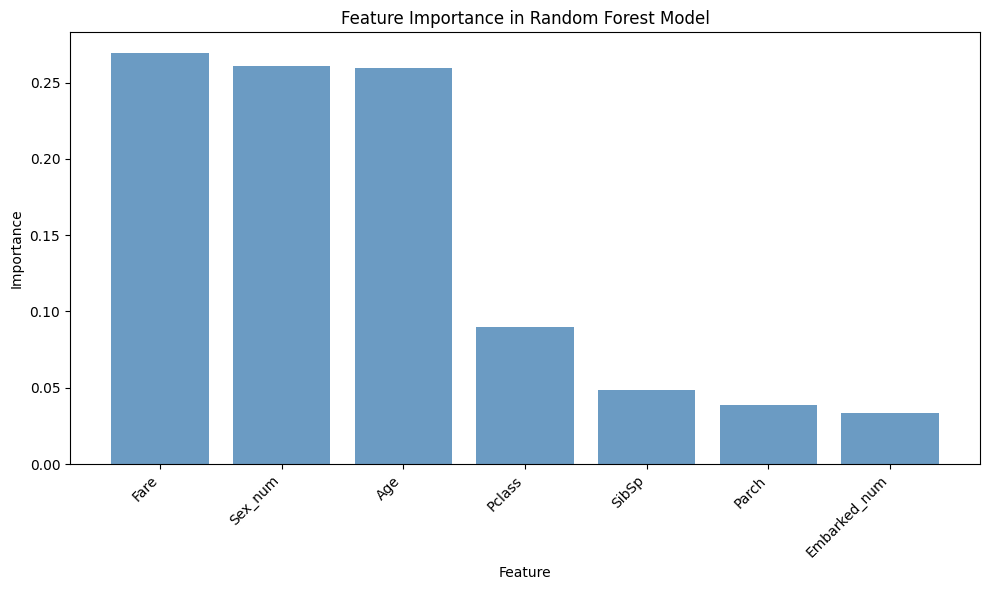

In [9]:
# Analyze feature importance
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Ranking:\n")
for i, idx in enumerate(indices, 1):
    print(f"{i}. {FEATURE_COLUMNS[idx]:15} -> {importances[idx]:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color='steelblue', alpha=0.8)
plt.xticks(range(len(importances)), [FEATURE_COLUMNS[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

### Hyperparameter Optimization

In [10]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Perform grid search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Searching for optimal hyperparameters...")
grid_search.fit(X_train, y_train)

print(f"\nBest hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Searching for optimal hyperparameters...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8350


### Baseline Model Evaluation

In [11]:
# Get best model from grid search
best_rf = grid_search.best_estimator_

# Generate predictions on training set
y_pred = best_rf.predict(X_train)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_train, y_pred, target_names=['Not Survived', 'Survived']))

Confusion Matrix:
[[527  22]
 [ 50 292]]

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.91      0.96      0.94       549
    Survived       0.93      0.85      0.89       342

    accuracy                           0.92       891
   macro avg       0.92      0.91      0.91       891
weighted avg       0.92      0.92      0.92       891



In [12]:
# Generate baseline predictions on test set
predictions = best_rf.predict(X_test)

print(f"Total predictions: {len(predictions)}")
print(f"Predicted survivors: {predictions.sum()}")
print(f"Predicted non-survivors: {len(predictions) - predictions.sum()}")
print(f"Survival rate: {predictions.mean():.2%}")
print(f"\nFirst 10 predictions: {predictions[:10]}")

Total predictions: 418
Predicted survivors: 141
Predicted non-survivors: 277
Survival rate: 33.73%

First 10 predictions: [0 0 0 0 0 0 0 0 1 0]


In [13]:
# Save baseline submission
submission = pl.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": predictions
})

submission.write_csv("../datasets/titanic/submission_baseline.csv")
print("✓ Baseline submission saved: submission_baseline.csv")
print("\nPreview:")
print(submission.head(10))

✓ Baseline submission saved: submission_baseline.csv

Preview:
shape: (10, 2)
┌─────────────┬──────────┐
│ PassengerId ┆ Survived │
│ ---         ┆ ---      │
│ i64         ┆ i64      │
╞═════════════╪══════════╡
│ 892         ┆ 0        │
│ 893         ┆ 0        │
│ 894         ┆ 0        │
│ 895         ┆ 0        │
│ 896         ┆ 0        │
│ 897         ┆ 0        │
│ 898         ┆ 0        │
│ 899         ┆ 0        │
│ 900         ┆ 1        │
│ 901         ┆ 0        │
└─────────────┴──────────┘


## Original Ensemble Model

In [14]:
# Create original ensemble with baseline features
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('svc', SVC(kernel='rbf', probability=True, random_state=42))
    ],
    voting='soft'
)

ensemble_model.fit(X_train, y_train)
ensemble_scores = cross_val_score(ensemble_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Ensemble Mean Accuracy: {ensemble_scores.mean():.4f} (+/- {ensemble_scores.std():.4f})")

Ensemble Mean Accuracy: 0.8238 (+/- 0.0293)


## Load Ground Truth for Error Analysis

In [15]:
# Load ground truth labels from submission file
ground_truth = pl.read_csv("../datasets/titanic/gender_submission.csv")
y_test_true = ground_truth["Survived"].to_numpy()

print(f"Ground truth loaded: {len(y_test_true)} labels")

Ground truth loaded: 418 labels


## Error Analysis Functions

Define functions to analyze prediction errors and understand model weaknesses.

In [16]:
def analyze_errors(X_test, y_true, y_pred, df_test, feature_names):
    """
    Analyze prediction errors to understand model weaknesses.
    
    Args:
        X_test: Test features
        y_true: True labels
        y_pred: Predicted labels
        df_test: Original test dataframe
        feature_names: List of feature names
    
    Returns:
        DataFrame with error analysis
    """
    # Identify misclassified samples
    errors = y_true != y_pred
    
    # Calculate accuracy
    accuracy = (y_true == y_pred).mean()
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Total errors: {errors.sum()} / {len(y_true)}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print("              Predicted")
    print("              No   Yes")
    print(f"Actual No  [{cm[0,0]:4d} {cm[0,1]:4d}]")
    print(f"       Yes [{cm[1,0]:4d} {cm[1,1]:4d}]")
    
    # False positives and false negatives
    false_positives = (y_true == 0) & (y_pred == 1)
    false_negatives = (y_true == 1) & (y_pred == 0)
    
    print(f"\nFalse Positives (predicted survived but died): {false_positives.sum()}")
    print(f"False Negatives (predicted died but survived): {false_negatives.sum()}")
    
    # Create error analysis dataframe
    error_df = df_test.clone()
    error_df = error_df.with_columns([
        pl.Series("True_Survived", y_true),
        pl.Series("Predicted", y_pred),
        pl.Series("Error", errors)
    ])
    
    return error_df

In [17]:
def analyze_error_patterns(error_df):
    """
    Analyze patterns in misclassified samples.
    
    Args:
        error_df: DataFrame with error analysis
    """
    # Filter only errors
    errors_only = error_df.filter(pl.col("Error") == True)
    
    if len(errors_only) == 0:
        print("No errors to analyze!")
        return
    
    print(f"\n{'='*60}")
    print("ERROR PATTERN ANALYSIS")
    print(f"{'='*60}\n")
    
    # Analyze by Pclass
    print("Errors by Passenger Class:")
    error_by_class = errors_only.group_by("Pclass").agg([
        pl.len(),
        pl.col("Sex").value_counts().alias("sex_distribution")
    ]).sort("Pclass")
    print(error_by_class)
    
    # Analyze by Sex
    print("\nErrors by Sex:")
    error_by_sex = errors_only.group_by("Sex").agg([
        pl.len(),
        pl.col("Age").mean().alias("avg_age"),
        pl.col("Fare").mean().alias("avg_fare")
    ])
    print(error_by_sex)
    
    # Age distribution of errors
    print("\nAge Statistics in Errors:")
    print(errors_only.select(pl.col("Age")).describe())
    
    # Analyze false positives vs false negatives
    false_pos = errors_only.filter(pl.col("Predicted") == 1)
    false_neg = errors_only.filter(pl.col("Predicted") == 0)
    
    print(f"\nFalse Positives (predicted survived incorrectly):")
    print(f"  - Count: {len(false_pos)}")
    print(f"  - Avg Fare: {false_pos['Fare'].mean():.2f}")
    print(f"  - Most common class: {false_pos['Pclass'].mode()[0]}")
    
    print(f"\nFalse Negatives (predicted died incorrectly):")
    print(f"  - Count: {len(false_neg)}")
    print(f"  - Avg Fare: {false_neg['Fare'].mean():.2f}")
    print(f"  - Most common class: {false_neg['Pclass'].mode()[0]}")

### Execute Error Analysis

In [18]:
# Analyze baseline model errors
error_analysis = analyze_errors(X_test, y_test_true, predictions, df_test, FEATURE_COLUMNS)
analyze_error_patterns(error_analysis)

Test Accuracy: 0.8684
Total errors: 55 / 418

Confusion Matrix:
              Predicted
              No   Yes
Actual No  [ 244   22]
       Yes [  33  119]

False Positives (predicted survived but died): 22
False Negatives (predicted died but survived): 33

ERROR PATTERN ANALYSIS

Errors by Passenger Class:
shape: (3, 3)
┌────────┬─────┬─────────────────────────────┐
│ Pclass ┆ len ┆ sex_distribution            │
│ ---    ┆ --- ┆ ---                         │
│ i64    ┆ u32 ┆ list[struct[2]]             │
╞════════╪═════╪═════════════════════════════╡
│ 1      ┆ 12  ┆ [{"male",12}]               │
│ 2      ┆ 2   ┆ [{"male",2}]                │
│ 3      ┆ 41  ┆ [{"female",33}, {"male",8}] │
└────────┴─────┴─────────────────────────────┘

Errors by Sex:
shape: (2, 4)
┌────────┬─────┬───────────┬───────────┐
│ Sex    ┆ len ┆ avg_age   ┆ avg_fare  │
│ ---    ┆ --- ┆ ---       ┆ ---       │
│ str    ┆ u32 ┆ f64       ┆ f64       │
╞════════╪═════╪═══════════╪═══════════╡
│ female ┆ 33  ┆ 2

## Advanced Features Engineering

In [19]:
def create_advanced_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Create advanced engineered features based on domain knowledge.
    
    Args:
        df: Preprocessed DataFrame
    
    Returns:
        DataFrame with additional features
    """
    df = df.with_columns([
        # Family size
        (pl.col("SibSp") + pl.col("Parch") + 1).alias("FamilySize"),
        
        # Is alone
        ((pl.col("SibSp") == 0) & (pl.col("Parch") == 0)).cast(pl.Int32).alias("IsAlone"),
        
        # Age groups
        pl.when(pl.col("Age") < 12).then(0)
          .when(pl.col("Age") < 18).then(1)
          .when(pl.col("Age") < 60).then(2)
          .otherwise(3).alias("AgeGroup"),
        
        # Fare per person
        (pl.col("Fare") / (pl.col("SibSp") + pl.col("Parch") + 1)).alias("FarePerPerson"),
    ])
    
    # Fare bins
    df = df.with_columns([
        pl.when(pl.col("Fare") <= 7.91).then(0)
          .when(pl.col("Fare") <= 14.454).then(1)
          .when(pl.col("Fare") <= 31).then(2)
          .otherwise(3).alias("FareBin")
    ])
    
    return df

# Create advanced features
df_train_advanced = create_advanced_features(df_train)
df_test_advanced = create_advanced_features(df_test)

# New feature list
ADVANCED_FEATURES = FEATURE_COLUMNS + ["FamilySize", "IsAlone", "AgeGroup", "FarePerPerson", "FareBin"]

print(f"✓ Advanced features created: {len(ADVANCED_FEATURES)} features total")

✓ Advanced features created: 12 features total


## Prepare Data with Advanced Features

In [20]:
# Prepare advanced features for training
X_train_advanced = df_train_advanced.select(ADVANCED_FEATURES).to_numpy()
X_test_advanced = df_test_advanced.select(ADVANCED_FEATURES).to_numpy()

print(f"Advanced training features shape: {X_train_advanced.shape}")
print(f"Advanced test features shape: {X_test_advanced.shape}")
print(f"Feature count increased from {len(FEATURE_COLUMNS)} to {len(ADVANCED_FEATURES)}")

Advanced training features shape: (891, 12)
Advanced test features shape: (418, 12)
Feature count increased from 7 to 12


## Normalize Features for Scaling-Sensitive Algorithms

In [21]:
# Normalize features for algorithms sensitive to scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_advanced)
X_test_scaled = scaler.transform(X_test_advanced)

print("✓ Features normalized for SGD and SVM")
print(f"Mean of scaled features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled features: {X_train_scaled.std():.6f}")

✓ Features normalized for SGD and SVM
Mean of scaled features: -0.000000
Std of scaled features: 1.000000


## Optimized Ensemble with Advanced Features

Train individual models and create an optimized ensemble.

In [22]:
# Define models with advanced features
rf_advanced = RandomForestClassifier(
    n_estimators=200, 
    max_depth=25, 
    min_samples_split=3,
    random_state=42
)

gb_advanced = GradientBoostingClassifier(
    n_estimators=150, 
    learning_rate=0.08, 
    max_depth=5,
    random_state=42
)

lr_advanced = LogisticRegression(max_iter=1000, random_state=42)
svc_advanced = SVC(kernel='rbf', probability=True, C=1.0, random_state=42)

# Train Random Forest and Gradient Boosting on advanced features (no scaling needed)
print("Training Random Forest with advanced features...")
rf_advanced.fit(X_train_advanced, y_train)
rf_advanced_cv = cross_val_score(rf_advanced, X_train_advanced, y_train, cv=5, scoring='accuracy')

print("Training Gradient Boosting with advanced features...")
gb_advanced.fit(X_train_advanced, y_train)
gb_advanced_cv = cross_val_score(gb_advanced, X_train_advanced, y_train, cv=5, scoring='accuracy')

# Train Logistic Regression and SVM on scaled features
print("Training Logistic Regression with scaled features...")
lr_advanced.fit(X_train_scaled, y_train)
lr_advanced_cv = cross_val_score(lr_advanced, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Training SVM with scaled features...")
svc_advanced.fit(X_train_scaled, y_train)
svc_advanced_cv = cross_val_score(svc_advanced, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("\n" + "="*70)
print("INDIVIDUAL MODEL PERFORMANCE WITH ADVANCED FEATURES")
print("="*70)
print(f"Random Forest Advanced      | Mean: {rf_advanced_cv.mean():.4f} (+/- {rf_advanced_cv.std():.4f})")
print(f"Gradient Boosting Advanced  | Mean: {gb_advanced_cv.mean():.4f} (+/- {gb_advanced_cv.std():.4f})")
print(f"Logistic Regression Scaled  | Mean: {lr_advanced_cv.mean():.4f} (+/- {lr_advanced_cv.std():.4f})")
print(f"SVM Scaled                  | Mean: {svc_advanced_cv.mean():.4f} (+/- {svc_advanced_cv.std():.4f})")
print("="*70)

Training Random Forest with advanced features...
Training Gradient Boosting with advanced features...
Training Logistic Regression with scaled features...
Training SVM with scaled features...

INDIVIDUAL MODEL PERFORMANCE WITH ADVANCED FEATURES
Random Forest Advanced      | Mean: 0.8137 (+/- 0.0177)
Gradient Boosting Advanced  | Mean: 0.8261 (+/- 0.0270)
Logistic Regression Scaled  | Mean: 0.7958 (+/- 0.0185)
SVM Scaled                  | Mean: 0.8227 (+/- 0.0137)


In [23]:
# Create optimized ensemble with pipelines for scaled models
scaled_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

scaled_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', probability=True, C=1.0, random_state=42))
])

# Build the final optimized ensemble
optimized_ensemble = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=25, min_samples_split=3, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=150, learning_rate=0.08, max_depth=5, random_state=42)),
        ('lr', scaled_lr),
        ('svc', scaled_svc)
    ],
    voting='soft'
)

# Train the optimized ensemble
print("Training Optimized Ensemble...")
optimized_ensemble.fit(X_train_advanced, y_train)

# Evaluate
opt_ensemble_cv = cross_val_score(optimized_ensemble, X_train_advanced, y_train, cv=5, scoring='accuracy')

print(f"\n{'='*70}")
print(f"OPTIMIZED ENSEMBLE PERFORMANCE")
print(f"{'='*70}")
print(f"Mean Accuracy: {opt_ensemble_cv.mean():.4f} (+/- {opt_ensemble_cv.std():.4f})")
print(f"Scores: {opt_ensemble_cv}")
print(f"{'='*70}")

# Compare with original ensemble
improvement = opt_ensemble_cv.mean() - ensemble_scores.mean()
print(f"\n✓ Improvement over original ensemble: {improvement:+.4f} ({improvement/ensemble_scores.mean()*100:+.2f}%)")

Training Optimized Ensemble...

OPTIMIZED ENSEMBLE PERFORMANCE
Mean Accuracy: 0.8373 (+/- 0.0201)
Scores: [0.83240223 0.84269663 0.84269663 0.80337079 0.86516854]

✓ Improvement over original ensemble: +0.0134 (+1.63%)


## Final Predictions with Optimized Model

In [24]:
# Generate final predictions using optimized ensemble
predictions_optimized = optimized_ensemble.predict(X_test_advanced)

print(f"Total predictions: {len(predictions_optimized)}")
print(f"Predicted survivors: {predictions_optimized.sum()}")
print(f"Predicted non-survivors: {len(predictions_optimized) - predictions_optimized.sum()}")
print(f"Survival rate: {predictions_optimized.mean():.2%}")

# Compare with baseline predictions
matches = (predictions == predictions_optimized).sum()
differences = (predictions != predictions_optimized).sum()

print(f"\nComparison with Baseline Predictions:")
print(f"  - Same predictions: {matches} ({matches/len(predictions)*100:.1f}%)")
print(f"  - Different predictions: {differences} ({differences/len(predictions)*100:.1f}%)")

Total predictions: 418
Predicted survivors: 141
Predicted non-survivors: 277
Survival rate: 33.73%

Comparison with Baseline Predictions:
  - Same predictions: 394 (94.3%)
  - Different predictions: 24 (5.7%)


## Save Optimized Submission

In [25]:
# Save optimized submission
submission_optimized = pl.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": predictions_optimized
})

submission_optimized.write_csv("../datasets/titanic/submission_optimized_ensemble.csv")

print("✓ Optimized submission saved: submission_optimized_ensemble.csv")
print("\nPreview:")
print(submission_optimized.head(10))

✓ Optimized submission saved: submission_optimized_ensemble.csv

Preview:
shape: (10, 2)
┌─────────────┬──────────┐
│ PassengerId ┆ Survived │
│ ---         ┆ ---      │
│ i64         ┆ i64      │
╞═════════════╪══════════╡
│ 892         ┆ 0        │
│ 893         ┆ 0        │
│ 894         ┆ 0        │
│ 895         ┆ 0        │
│ 896         ┆ 0        │
│ 897         ┆ 0        │
│ 898         ┆ 0        │
│ 899         ┆ 0        │
│ 900         ┆ 1        │
│ 901         ┆ 0        │
└─────────────┴──────────┘


## Final Performance Summary

In [26]:
# Final comparison summary
print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*80)

models_summary = {
    'Baseline Random Forest': scores.mean(),
    'Original Ensemble': ensemble_scores.mean(),
    'Optimized Ensemble (Adv Features)': opt_ensemble_cv.mean()
}

max_accuracy = max(models_summary.values())
baseline = models_summary['Baseline Random Forest']

for model_name, accuracy in models_summary.items():
    improvement = accuracy - baseline
    percentage = (improvement / baseline) * 100
    star = " ⭐ BEST" if accuracy == max_accuracy else ""
    print(f"{model_name:40} | Accuracy: {accuracy:.4f} | Δ: {improvement:+.4f} ({percentage:+.2f}%){star}")

print("="*80)
print(f"\n✓ Total improvement: {max_accuracy - baseline:.4f} ({(max_accuracy - baseline)/baseline*100:.2f}%)")
print("✓ Model is ready for submission!")


FINAL MODEL PERFORMANCE SUMMARY
Baseline Random Forest                   | Accuracy: 0.8137 | Δ: +0.0000 (+0.00%)
Original Ensemble                        | Accuracy: 0.8238 | Δ: +0.0101 (+1.24%)
Optimized Ensemble (Adv Features)        | Accuracy: 0.8373 | Δ: +0.0236 (+2.90%) ⭐ BEST

✓ Total improvement: 0.0236 (2.90%)
✓ Model is ready for submission!
